# Classification model: DeBERTa

This notebook contains DeBERTa model building, training and evaluation.

In [1]:
import numpy as np
import pandas as pd
import math
import json

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras_nlp
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend


### Read the splitted datasets

In [2]:
with open('./datasets/data_train_new.json', 'r') as f:
    data_train = json.load(f)

with open('./datasets/data_valid_new.json', 'r') as f:
    data_valid = json.load(f)

with open('./datasets/data_test_new.json', 'r') as f:
    data_test = json.load(f)

train_df = pd.DataFrame(data_train)
valid_df = pd.DataFrame(data_valid)
test_df = pd.DataFrame(data_test)

### Model building

In [13]:
SEQUENCE_LENGTH = 128
BATCH_SIZE = 32
REPLICAS = 1
PRESET = 'deberta_v3_base_en'
EPOCHS = 10
SEED = 0

In [14]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=PRESET,
    sequence_length=SEQUENCE_LENGTH
)

2023-12-18 22:39:19.668068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-18 22:39:19.668100: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-18 22:39:19.668106: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-18 22:39:19.668335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 22:39:19.668701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    
    return (text, label) if label is not None else text

def encode_labels_fn(text, label):
    return (text, tf.one_hot(label, depth=3))

def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    # ds = ds.map(encode_labels_fn, num_parallel_calls=AUTO)
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=SEED)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [16]:
def get_datasets():
    train_texts = train_df.text.tolist()
    train_labels = train_df.label.tolist()
    
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=BATCH_SIZE * REPLICAS, cache=False,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(BATCH_SIZE * REPLICAS, len(valid_df)), cache=False,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

In [18]:
def get_callbacks():
    callbacks = []
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'./weights/deberta_new.keras',
                                              monitor='val_acc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([ckpt_cb])  # Add lr and checkpoint callbacks
    
    return callbacks

In [19]:
def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        PRESET,
        preprocessor=None,
        num_classes=3
    )
    inputs = classifier.input
    logits = classifier(inputs)
    
    # Compute final output
    outputs = keras.layers.Activation('softmax')(logits)
    model = keras.Model(inputs, outputs)
    
    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(5e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc'),
        ],
        jit_compile=False # JIT is not supported for Macs with Apple Sillicon
    )
    return model

In [20]:
model = build_model()

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 padding_mask (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 token_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 deberta_v3_classifier (Deb  (None, 3)                    1844244   ['padding_mask[0][0]',        
 ertaV3Classifier)                                        51         'token_ids[0][0]']           
                                                                                                  
 activation (Activation)     (None, 3)                    0         ['deberta_v3_classifier[0]

In [22]:
(train_ds, train_df), (valid_ds, valid_df) = get_datasets()

callbacks = get_callbacks()

### Train the model

In [41]:
print('#' * 50)

# Start training the model
history = model.fit(
    train_ds,
    epochs=3,
    validation_data=valid_ds,
    callbacks=callbacks,
    steps_per_epoch=int(len(train_df) / BATCH_SIZE / REPLICAS),
)

# Find the epoch with the best validation accuracy
best_epoch = np.argmax(model.history.history['val_acc'])
best_auc = model.history.history['val_acc'][best_epoch]
best_loss = model.history.history['val_loss'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST ACCURACY   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
print('=' * 50)

##################################################
Epoch 1/3
70/70 [==============================] - 701s 10s/step - loss: 0.2991 - acc: 0.8978 - val_loss: 0.1929 - val_acc: 0.9486
Epoch 2/3
70/70 [==============================] - 732s 10s/step - loss: 0.2473 - acc: 0.9129 - val_loss: 0.1421 - val_acc: 0.9617
Epoch 3/3
70/70 [==============================] - 771s 11s/step - loss: 0.1803 - acc: 0.9446 - val_loss: 0.1164 - val_acc: 0.9597

================= RESULTS =================
>>>> BEST Loss  : 0.142
>>>> BEST ACCURACY   : 0.962
>>>> BEST Epoch : 1


### Evaluation on the test dataset

In [42]:
test_texts = test_df.text.tolist()
test_labels = test_df.label.tolist()

# Build test dataset
test_ds = build_dataset(test_texts, test_labels,
                             batch_size=125, cache=False,
                             shuffle=False, drop_remainder=True, repeat=False)

In [43]:
score, acc = model.evaluate(test_ds, batch_size=125)

3/3 [==============================] - 42s 14s/step - loss: 0.2424 - acc: 0.9147


In [44]:
print(f'Test score: {score}')
print(f'Test acc: {acc}')

Test score: 0.2424151599407196
Test acc: 0.9146666526794434


In [45]:
predictions = model.predict(
    test_ds,
    batch_size=125,
    verbose=1
)

3/3 [==============================] - 33s 10s/step


In [46]:
true_labels = test_df.label.values
pred_labels = predictions.argmax(axis=1)

In [47]:
len(pred_labels)

375

In [48]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [49]:
pred_labels

array([0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Metrics

In [50]:
accuracy_score(true_labels, pred_labels), precision_score(true_labels, pred_labels, average='macro'), recall_score(true_labels, pred_labels, average='macro')

(0.9146666666666666, 0.9249836462771178, 0.9146666666666666)

### Confusion matrix

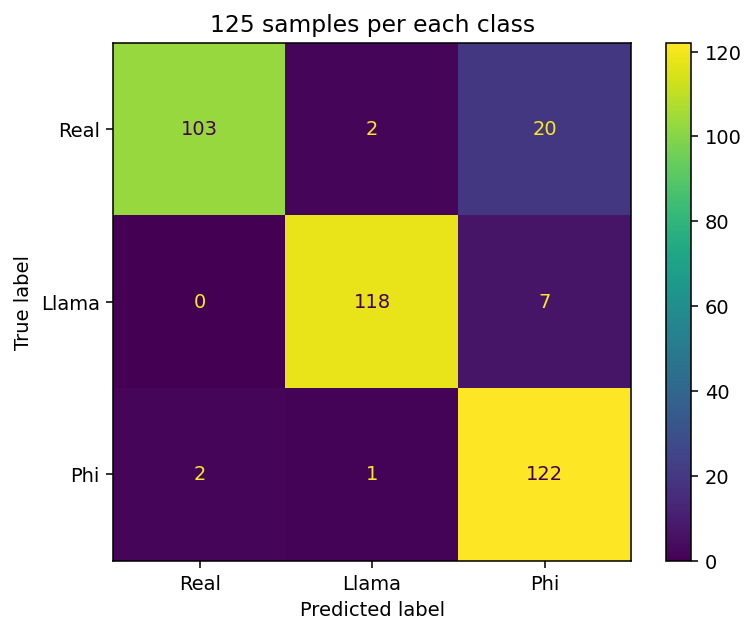

In [58]:
mpl.rcParams['figure.dpi'] = 140

cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Llama', 'Phi'])
disp.plot()

plt.title('125 samples per each class')
plt.show()